In [1]:
import yfinance as yf
import pandas as pd
def optimal_insurance_put(symbol):
    ticker=yf.Ticker(symbol)
    current_price=yf.download(symbol)['Adj Close'][-1]
    puts=ticker.option_chain().puts
    optimal_puts=puts[(puts['strike']>0.9*(current_price)) & (puts['strike']<1.1*(current_price))]
    optimal_puts['Insurance cost']=optimal_puts['strike']-optimal_puts['ask']-current_price

    purchasable_op=optimal_puts[(optimal_puts['strike']<current_price)]
    purchasable_op['Cost margin']=purchasable_op['Insurance cost']/current_price
    ideal_option=purchasable_op[purchasable_op['Insurance cost']==purchasable_op['Insurance cost'].min()]

    return ideal_option


In [2]:
optimal_insurance_put('AAPL')

[*********************100%%**********************]  1 of 1 completed
/var/folders/mk/fn7b709x3dz4m442ngj1_xf00000gn/T/ipykernel_353/2668414907.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimal_puts['Insurance cost']=optimal_puts['strike']-optimal_puts['ask']-current_price
/var/folders/mk/fn7b709x3dz4m442ngj1_xf00000gn/T/ipykernel_353/2668414907.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchasable_op['Cost margin']=purchasable_op['Insurance cost']/current_price


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Insurance cost,Cost margin
25,AAPL241025P00212500,2024-10-18 19:36:26+00:00,212.5,0.06,0.05,0.06,-0.05,-45.454548,50.0,2177.0,0.338874,False,REGULAR,USD,-22.56,-0.096


### Testing average cost of insurance puts for above function

In [4]:
tickers=['AMZN','BP','MSFT','TTE','AAPL','NVDA']
margin=[]
for ticker in tickers:
    margin.append(optimal_puts(ticker)['Cost margin'].tolist())

margin = [item for sublist in margin for item in sublist]

print(f'{round(sum(margin)/len(tickers)*100,2)}%')

NameError: name 'optimal_puts' is not defined

## Aggresive options strategy (CALLS)

In [5]:
def optimal_insurance_put(symbol):
    ticker=yf.Ticker(symbol)
    current_price=yf.download(symbol)['Adj Close'][-1]
    puts=ticker.option_chain().call
    optimal_puts=puts[(puts['strike']>0.9*(current_price)) & (puts['strike']<1.1*(current_price))]
    optimal_puts['Insurance cost']=optimal_puts['strike']-optimal_puts['ask']-current_price

    purchasable_op=optimal_puts[(optimal_puts['strike']<current_price)]
    purchasable_op['Cost margin']=purchasable_op['Insurance cost']/current_price
    ideal_option=purchasable_op[purchasable_op['Insurance cost']==purchasable_op['Insurance cost'].min()]

    return ideal_option

In [6]:
symbol='AAPL'
ticker=yf.Ticker(symbol)
current_price=yf.download(symbol)['Adj Close'][-1]
calls=ticker.option_chain().calls
calls['Status']=''
for i in range(len(calls)):
    if current_price>calls['strike'][i]+calls['bid'][i]:
        calls['Status'][i]=="Buy Right now"

    elif current_price>calls['strike'][i]:
        calls['Status'][i]=="Buy considering Bid price"


[*********************100%%**********************]  1 of 1 completed


In [7]:
calls.max()

contractSymbol             AAPL241025C00300000
lastTradeDate        2024-10-18 20:00:00+00:00
strike                                   300.0
lastPrice                               126.68
bid                                     134.25
ask                                     135.85
change                                9.970001
percentChange                            100.0
volume                                   42169
openInterest                             34909
impliedVolatility                     2.328129
inTheMoney                                True
contractSize                           REGULAR
currency                                   USD
Status                                        
dtype: object

In [8]:
import numpy as np
from scipy.stats import norm
import math
calls['d_1']=(np.log(current_price/calls['strike'])+(0.02+(calls['impliedVolatility']/2))*5)/(calls['impliedVolatility']*np.sqrt(5))#Where t==5
calls['d_2']=calls['d_1']-calls['impliedVolatility']*np.sqrt(5)


cdf_1=norm.cdf(calls['d_1'])
cdf_2=norm.cdf(calls['d_2'])
calls['BSM call val']=cdf_1*current_price-(cdf_2*calls['strike']*math.exp(-0.02*5))



In [9]:
calls['Diff to mkt']=abs(calls['BSM call val']-current_price)

In [10]:

pd.DataFrame(calls.loc[calls['Diff to mkt'].idxmax()])

,34
contractSymbol,AAPL241025C00245000
lastTradeDate,2024-10-18 19:59:48+00:00
strike,245.0
lastPrice,0.13
bid,0.11
ask,0.13
change,0.02
percentChange,18.181814
volume,7651
openInterest,15900


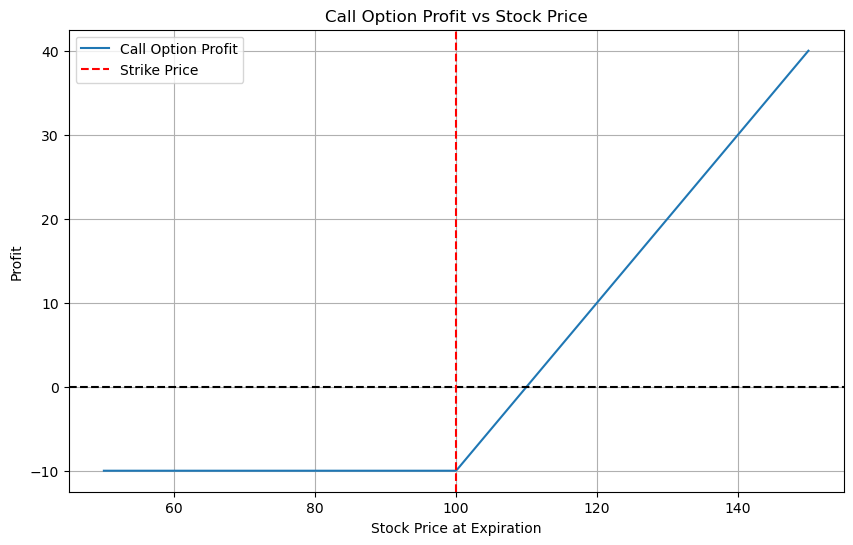

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
strike_price = 100  # Strike price of the call option
premium = 10        # Premium paid for the call option

# Range of stock prices
stock_prices = np.linspace(50, 150, 400)

# Calculate profit
profit = np.maximum(stock_prices - strike_price, 0) - premium

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(stock_prices, profit, label='Call Option Profit')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(strike_price, color='red', linestyle='--', label='Strike Price')
plt.title('Call Option Profit vs Stock Price')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Profit')
plt.legend()
plt.grid(True)
plt.show()